In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

#beta diversity
from scipy.spatial import distance
#rho
from scipy import stats

In [3]:
%pwd

'/home/MCB/zkarwowska/AE'

In [28]:
''' rarefied_history = pd.read_csv('rarefied_history.csv', index_col = [0])
mbimpute_history = pd.read_csv('mbimpute_history.csv', index_col = [0])

rarefied_pred = pd.read_csv('sVAR2_rarefied_df.csv', header = None, skiprows = [0], names=rarefied_history.columns)
mbimpute_pred = pd.read_csv('sVAR2_mbimpute_df.csv', header = None, skiprows = [0], names=rarefied_history.columns)

rarefied_pred[rarefied_pred<0]=0 
mbimpute_pred[mbimpute_pred<0]=0 '''

In [40]:
history = pd.read_csv('ae_svar/history_train.csv', index_col=[0])
prediction =pd.read_csv('ae_svar/prediction_train.csv', index_col=[0])

### RHO

In [5]:
def calculate_spearman_rho(PREDICTION, HISTORY, MODEL):
    
    RHO_imputed = []
    PVAL = []

    for col in HISTORY.columns:
        x = HISTORY[col]
        y = PREDICTION[col]

        rho, pval = stats.spearmanr(x, y)
        RHO_imputed.append(rho)
    

    rho = pd.DataFrame(RHO_imputed, columns = ['rho'])
    rho['MODEL'] = MODEL
    rho['bacteria'] = HISTORY.columns
    
    return rho

In [118]:
'''RAREFIED_RHO = calculate_spearman_rho(rarefied_pred, rarefied_history, 'no_imputation')
mbIMPUTED_RHO = calculate_spearman_rho(mbimpute_pred, mbimpute_history, 'imputation')

RHO = RAREFIED_RHO.append(mbIMPUTED_RHO)'''

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [41]:
RHO = calculate_spearman_rho(history, prediction, 'ae')

/home/MCB/zkarwowska/anaconda3/envs/deep_ae/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [119]:
RHO[RHO['rho'] <0]['bacteria'].tolist()

['TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGTGTAGGTGGCCAGGCAAGTCAGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTG',
 'TACGTAGGGGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGAGAAGCAAGTCAGTGGTGAAAACGATGGGCTTAACTCATCGACTG',
 'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACCCCAGGACTG']

In [ ]:
ax=sns.lineplot(x = rarefied_history.index, 
             y = rarefied_history['TACGTAGGGGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGAGAAGCAAGTCAGTGGTGAAAACGATGGGCTTAACTCATCGACTG'],
               color='Black')

ax=sns.lineplot(x = rarefied_pred.index, 
             y = rarefied_pred['TACGTAGGGGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGAGAAGCAAGTCAGTGGTGAAAACGATGGGCTTAACTCATCGACTG'],
               color = "Orange")

plt.show()

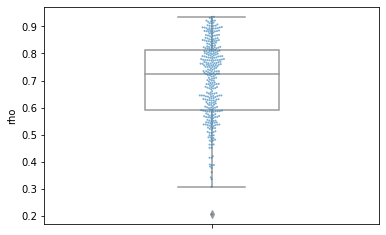

In [42]:
sns.boxplot(data = RHO, y = RHO['rho'], color = 'white', orient = 'v', width = .4)
sns.swarmplot(data =RHO, y = RHO['rho'], s = 2, alpha = .6, orient = 'v')
plt.savefig('ae_svar/rho_prediction.png')

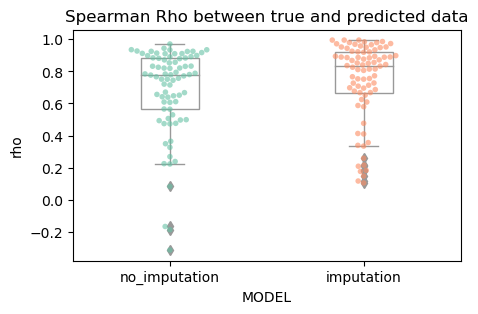

In [121]:
plt.figure(figsize = [5, 3])

sns.boxplot(
    y = RHO['rho'],
    x = RHO['MODEL'],
    width = .3,
    color = 'White',
    linewidth = 1
)

sns.swarmplot(
    y = RHO['rho'],
    x = RHO['MODEL'],
    palette='Set2',
    alpha = .6,
    s=4
)

plt.title('Spearman Rho between true and predicted data')
plt.savefig('rho.png')
plt.show()

### nRMSE

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
def calculate_rmse_bacteria(PREDICTION, HISTORY, MODEL):
    
    normalised_nRMSE = []
    COL = []

    for col in PREDICTION.columns.tolist():

        TRUE = HISTORY[col]    
        FORECAST = PREDICTION[col]

        divider = TRUE.max() - TRUE.min() #+ 0.00001
        RMSE = mean_squared_error(TRUE, FORECAST, squared=False)
        nRMSE = RMSE/divider

        normalised_nRMSE.append(nRMSE)
        COL.append(col)

    nRMSE_COL = pd.DataFrame(list(zip(COL, normalised_nRMSE)), columns = ['BACTERIA', 'NRMSE'])
    nRMSE_COL['MODEL'] = MODEL
    
    return nRMSE_COL

In [123]:
RAREFIED_NRMSE = calculate_rmse_bacteria(rarefied_pred, rarefied_history, 'no_imputation')
mbIMPUTED_NRMSE = calculate_rmse_bacteria(mbimpute_pred, mbimpute_history, 'imputation')

nRMSE = mbIMPUTED_NRMSE.append(RAREFIED_NRMSE)

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [43]:
nRMSE = calculate_rmse_bacteria(history, prediction, 'ae')

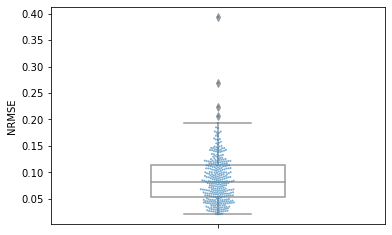

In [46]:
sns.boxplot(data = nRMSE, y = nRMSE['NRMSE'], color = 'white', orient = 'v', width = .4)
sns.swarmplot(data =nRMSE, y = nRMSE['NRMSE'], s = 2, alpha = .6, orient = 'v')
plt.savefig('ae_svar/nrmse_prediction.png')

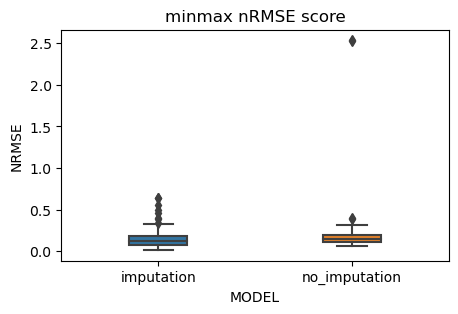

In [124]:
plt.figure(figsize = [5, 3])
sns.boxplot(y = nRMSE['NRMSE'],
            x = nRMSE['MODEL'],
            width = .3)

plt.title('minmax nRMSE score')
plt.savefig('nrmse.png')
plt.show()

### Bray Curtis

In [47]:
def calculate_BC(HISTORY, PREDICTION, MODEL):
    
    PREDICTION.index = HISTORY.index
    
    BRAY_CURTIS = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        bray_curtis = distance.braycurtis(y_true,
                                          y_forecasted)

        BRAY_CURTIS.append(bray_curtis)

    bray_curtis_df = pd.DataFrame(BRAY_CURTIS,
                              columns = ['bc_distance'])

    bray_curtis_df['timestep'] = HISTORY.index
    bray_curtis_df['model'] = MODEL
    
    return bray_curtis_df

In [126]:
RAREFIED_BC = calculate_BC(rarefied_history, rarefied_pred, 'no_imputation')
mbIMPUTED_BC = calculate_BC(mbimpute_history, mbimpute_pred, 'imputation')

BC = mbIMPUTED_BC.append(RAREFIED_BC)

In [49]:
BC = calculate_BC(history, prediction, 'ae')

In [ ]:
sns.boxplot(data = BC, y = nRMSE['NRMSE'], color = 'white', orient = 'v', width = .4)
sns.swarmplot(data =nRMSE, y = nRMSE['NRMSE'], s = 2, alpha = .6, orient = 'v')
plt.savefig('ae_svar/nrmse_prediction.png')

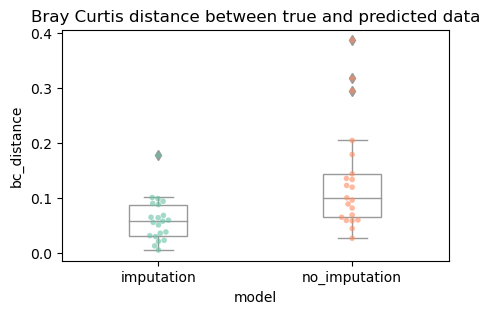

In [127]:
plt.figure(figsize = [5, 3])

sns.boxplot(
    y = BC['bc_distance'],
    x = BC['model'],
    width = .3,
    color = 'White',
    linewidth = 1
)

sns.swarmplot(
    y = BC['bc_distance'],
    x = BC['model'],
    palette='Set2',
    alpha = .6,
    s=4
)

plt.title('Bray Curtis distance between true and predicted data')
plt.savefig('BC.png')
plt.show()